In [87]:
from NeuralNetworks.activationfunctions import *
import numpy as np
import matplotlib.pyplot as plt


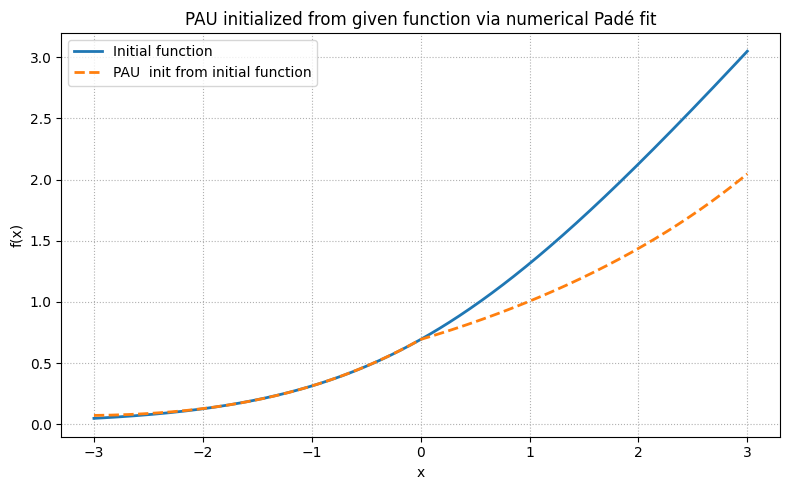

In [88]:
def test_PAU_initialization(n=5,m=4, init_func=torch.nn.Softplus()):
    act = PAU(n_numerator=n, n_denominator=m, init_func=init_func)

    x = torch.linspace(-3, 3, 600, dtype=torch.float32)
    with torch.no_grad():
        y_true = init_func(x)
        y_pau  = act(x)

    x_np = x.cpu().numpy()
    plt.figure(figsize=(8, 5))
    plt.plot(x_np, y_true.cpu().numpy(), label="Initial function", linewidth=2)
    plt.plot(x_np, y_pau.cpu().numpy(), "--", label="PAU  init from initial function", linewidth=2)
    plt.title("PAU initialized from given function via numerical Padé fit")
    plt.xlabel("x"); plt.ylabel("f(x)")
    plt.legend(); plt.grid(True, linestyle=":")
    plt.tight_layout()
    plt.show()

test_PAU_initialization(n=2,m=2, init_func = torch.nn.Softplus())

### Heat Equation

$$u_t = u_{xx}$$





In [89]:
from scipy.sparse import diags
from scipy.linalg import lu_factor, lu_solve

def create_sparse_tridiagonal(n, a = 1, b = -2, c = 1):
    diagonals = [np.full(n-1, a), np.full(n, b), np.full(n-1, c)]
    return diags(diagonals, offsets=[-1, 0, 1]).toarray()

In [90]:
def AVF(L= 1, N = 50, dt = 0.0025, T = 0.25, A = None):
    x = np.linspace(0, L, N + 1)
    dx = L / N
    N_t = int(T / dt)

    #Initial condition
    u = x*(1-x)

    #Periodic Dirichlet BCs, u(0)=u(L)=0
    u[0] = 0.0
    u[-1] = 0.0

    #Discrete Laplacian (negative definite N operator)
    if A is None:
        tridiag = create_sparse_tridiagonal(n=N-1)
        A = 1/dx**2*tridiag

    #(I - dt/2 * A) u^{n+1} = (I + dt/2 * A) u^n
    I = np.eye(N-1)
    LHS = I - 0.5 * dt * A
    RHS = I + 0.5 * dt * A

    #Precompute LU factorization for efficiency
    lu, piv = lu_factor(LHS)

    #Save every 10th time step
    u_all = [u.copy()]
    t_all = [0.0]

    for n in range(N_t):
        u_old = u[1:-1]
        rhs = RHS @ u_old
        u_new = lu_solve((lu, piv), rhs)
        u[1:-1] = u_new

        if (n + 1) % 10 == 0:
            u_all.append(u.copy())
            t_all.append((n + 1) * dt)

    return x, np.array(t_all), np.array(u_all)

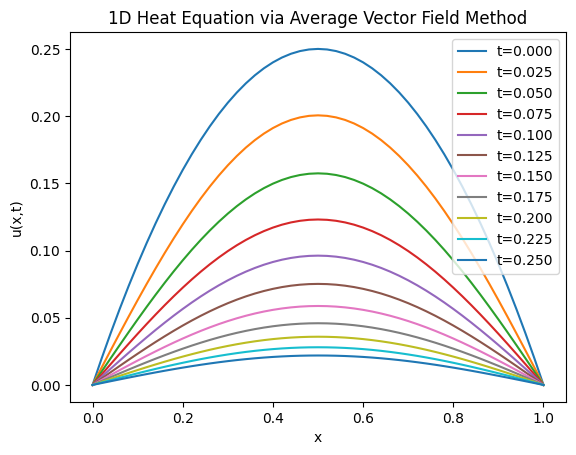

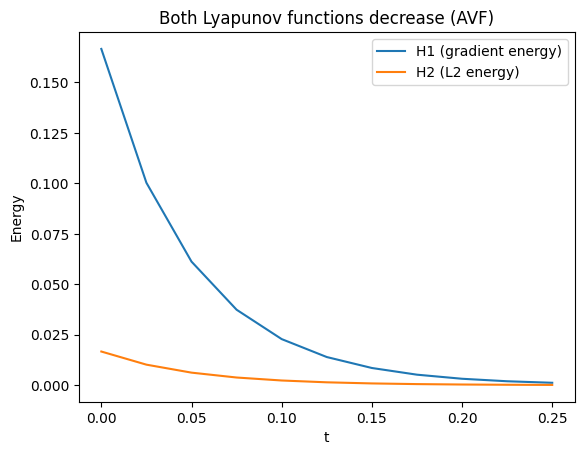

In [91]:
L=1.0
N=50
T=0.25
dt=0.0025

Rayleigh_number = 10

x, t, U = AVF(L=L, N=N, dt=dt, T=T)

plt.figure()
for i in range(len(t)):
    plt.plot(x, U[i], label=f"t={t[i]:.3f}")
plt.xlabel("x"); plt.ylabel("u(x,t)")
plt.title("1D Heat Equation via Average Vector Field Method")
plt.legend()
plt.show()

dx = x[1] - x[0]
A = (1/dx**2) * create_sparse_tridiagonal(n = N-1)
H1 = [0.5 * u[1:-1].T @ (-A) @ u[1:-1] * dx for u in U]
H2 = [0.5 * np.sum(u**2) * dx   for u in U]

scaling = H1[0] / H2[0]

plt.plot(t, H1, label='H1 (gradient energy)')
plt.plot(t, H2, label='H2 (L2 energy)')
plt.xlabel("t"); plt.ylabel("Energy")
plt.legend(); plt.title("Both Lyapunov functions decrease (AVF)")
plt.show()


In [92]:
print(H1[0] / H2[0])

9.99600159936033
